In [9]:
import tensorflow as tf
from losses import TrainState
from flax.training import checkpoints
from flax import jax_utils as flax_utils
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp

import functools


from models import super_simple
from models import utils as mutils
import sampling
import losses

from configs.vp.disk_ssim_continuous import get_config
import sde_lib
import datasets

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import os

In [2]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
rng = jax.random.PRNGKey(42)
model_rng, sampling_rng = jax.random.split(rng)
config = get_config()
score_model, init_model_state, init_model_params = mutils.init_model(model_rng, config)

In [4]:
optimizer = losses.get_optimizer(config)

state = TrainState.create(tx=optimizer, apply_fn=score_model.apply,
                          params=init_model_params, mutable_state=init_model_state,
                          rng=rng)

In [17]:
workdir = '/home/komodo/Documents/uni/thesis/song_sde'
ckpt_model_state = checkpoints.restore_checkpoint(os.path.join(workdir, 'checkpoints-meta'), state)

In [11]:
if config.training.sde.lower() == 'vpsde':
    sde = sde_lib.VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    sampling_eps = 1e-3
elif config.training.sde.lower() == 'subvpsde':
    sde = sde_lib.subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    sampling_eps = 1e-3
elif config.training.sde.lower() == 'vesde':
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-5
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")
inverse_scaler = datasets.get_data_inverse_scaler(config)

sampling_shape = (config.training.batch_size // jax.local_device_count(), config.data.image_size,
                config.data.image_size, config.data.num_channels)

In [12]:
# sampling_fn = pc_sampler
sampling_fn = sampling.get_sampling_fn(config, sde, score_model, sampling_shape, inverse_scaler, sampling_eps)

In [18]:
pstate = flax_utils.replicate(ckpt_model_state)
num_train_steps = config.training.n_iters

# In case there are multiple hosts (e.g., TPU pods), only log to host 0
rng = jax.random.fold_in(rng, jax.host_id())
rng, *next_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
next_rng = jnp.asarray(next_rng)

a, b = sampling_fn(next_rng, pstate)

/home/komodo/miniconda3/envs/testing/lib/python3.11/site-packages/jax/_src/xla_bridge.py:1174: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [19]:
a_sq = jnp.squeeze(a)
a_sq.shape

(128, 2)

In [20]:
jnp.mean(jnp.sum(a_sq**2, axis=1))

Array(26637.977, dtype=float32)

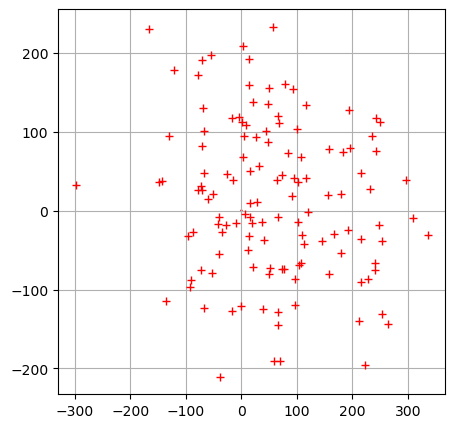

In [21]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)

circle = plt.Circle((0, 0), 1, color='r', fill=False)

xs = lambda r: a_sq[:, 0]
ys = lambda r: a_sq[:, 1]

ax.add_patch(circle)
line, = ax.plot(xs(0.6), ys(0.6), 'r+')
ax.grid(True)

plt.show()